# 각 유저 대상 모달 주요도 추출을 위한 MIL 모델 학습 예제 코드
## User name: 101

# 필요 모듈 로드

In [1]:
%cd /workspace             # human_lifelog_mil_pytorch 디렉토리 상위로 경로 설정

# 데이터 관련 필요 모듈
import numpy as np
import pandas as pd
import pickle
import os

# train, valid, testset 구분을 위한 모듈
from sklearn.model_selection import train_test_split

# MIL 모델 생성 및 학습에 필요한 코드
from human_lifelog_mil_pytorch.FocalLoss import FocalLoss
from human_lifelog_mil_pytorch.human_lifelog_mil_pytorch import MILNet
from human_lifelog_mil_pytorch.human_lifelog_mil_pytorch import HumanDataset
from human_lifelog_mil_pytorch.utils import getF1Score

import torch

# 학습 결과 시각화 모듈
import matplotlib.pyplot as plt

# 의미없는 경고 제거를 위한 모듈 및 코드
import warnings
warnings.filterwarnings( 'ignore' )

# 모델 성능 측정을 위한 모듈
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# 개별 유저를 대상으로는 Tension의 특정 코드가 생략될 경우 존재, 이를 해결하기 위한 모듈
from sklearn.preprocessing import LabelEncoder

# 학습 경과를 확인하기 위한 모듈
from tqdm import tqdm_notebook

device = torch.device("cuda:0")

/workspace


# 데이터 로드 및 전처리

In [2]:
# Dataset Preprocessor을 통해 생성한 101번 사용자의 전처리된 데이터프레임 생성
df = pd.read_pickle('/workspace/Data analysis (zaesoek)/2019/101_prpDf.pickle')

# 센서 입력이 중간에 잘못되어 길이가 다르게 입력된 outlier 제거
df = df.drop(df[df['e4AccLen']!=1920].index, 0)
df = df.drop(df[df['e4BvpLen']!=3840].index, 0)
df = df.drop(df[df['e4EdaLen']!=240].index, 0)
df = df.drop(df[df['e4TempLen']!=240].index, 0)

df = df.drop(df[df['mAccLen']<1786].index, 0)
df = df.drop(df[df['mGyrLen']<1786].index, 0)
df = df.drop(df[df['mMagLen']<1786].index, 0)

# 라벨이 될 수 있는 데이터 수치화(0, 1, ... 형태로 변환)
encoder = LabelEncoder()
df['action_label'] = encoder.fit_transform(df['action'])
encoder = LabelEncoder()
df['positive_label'] = encoder.fit_transform(df['emotionPositive'])
encoder = LabelEncoder()
df['tension_label'] = encoder.fit_transform(df['emotionTension'])


for i in df.index:
    # 아래 두 센서값은 길이가 고정되어 있지 않은 값이기 때문에 평균값을 모달 데이터로 선정
    df['e4Hr'][i] = np.mean(df['e4Hr'][i])
    df['mGps'][i] = np.mean(df['mGps'][i])
    
    # 길이가 다른 센서값 일부의 길이를 맞춰주는 코드
    if df['mAccLen'][i] == 1787:
        df['mAcc'][i] = df['mAcc'][i][:1786]
    if df['mGyrLen'][i] == 1787:
        df['mGyr'][i] = df['mGyr'][i][:1786]
    if df['mMagLen'][i] == 1787:
        df['mMag'][i] = df['mMag'][i][:1786]

df.head()

,userName,emotionPositive,emotionTension,action,gender,height,weight,e4Acc,e4Bvp,e4Eda,...,e4EdaLen,e4HrLen,e4TempLen,mAccLen,mGpsLen,mGyrLen,mMagLen,action_label,positive_label,tension_label
ts,,,,,,,,,,,,,,,,,,,,,
1578184440,101,6,2,recreation_etc,F,161.0,52.0,"[[0.9375, -0.25, -0.03125], [0.9375, -0.25, -0...","[[-0.5897236], [-2.0923119], [-3.8966255], [-5...","[[0.029454641], [0.029454641], [0.032015916], ...",...,240,32,240,1786,1,1786,1786,2,2,1
1578184560,101,6,2,recreation_etc,F,161.0,52.0,"[[0.9375, -0.21875, -0.0625], [0.9375, -0.2187...","[[-14.854795], [-17.59889], [-20.453917], [-22...","[[0.070435025], [0.0729963], [0.0729963], [0.0...",...,240,6,240,1786,1,1787,1787,2,2,1
1578184620,101,6,2,recreation_etc,F,161.0,52.0,"[[0.921875, -0.21875, -0.140625], [0.921875, -...","[[-5.4048615], [-6.8878326], [-9.298111], [-12...","[[0.08708331], [0.083241396], [0.085802674], [...",...,240,3,240,1786,1,1786,1786,2,2,1
1578184920,101,6,2,recreation_etc,F,161.0,52.0,"[[-0.28125, -0.578125, 0.734375], [-0.28125, -...","[[10.687408], [13.796631], [16.10376], [16.737...","[[0.15111516], [0.15367644], [0.1562377], [0.1...",...,240,8,240,1786,1,1786,1786,2,2,1
1578185040,101,6,2,recreation_etc,F,161.0,52.0,"[[-0.6875, -0.40625, 0.578125], [-0.6875, -0.4...","[[-5.266464], [-8.345547], [-11.21323], [-13.8...","[[0.13318624], [0.13446687], [0.13574752], [0....",...,240,64,240,1786,1,1787,1787,2,2,1


# 101번 사용자의 tension label 수 확인
- 101번 사용자의 tension label 수에 맞춘 개수의 Output을 내놓는 모델을 학습 예정

In [3]:
# tension Label 수 확인
df['tension_label'].unique()

array([1, 2, 0, 3])

# train, validation, test dataset split
- 7:1:2로 split

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle = True, random_state=32)
train_df, valid_df = train_test_split(train_df, test_size=0.125, shuffle = True, random_state=32)

print(len(train_df), len(valid_df), len(test_df))

trainset = HumanDataset(train_df)
validset = HumanDataset(valid_df)
testset = HumanDataset(test_df)

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=512, num_workers=0, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=32, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=0)

1290 185 369


# MIL 모델 생성
- class_num = tension 라벨 수
- optimizer는 AdamW 사용, lerning_rate는 1e-2로 세팅
- 각 라벨 사이에 불균형이 존재하기 때문에 Focal Loss 사용

In [5]:
milnet = MILNet(class_num = 4).to(device)
optimizer = torch.optim.AdamW(milnet.parameters(), 1e-2)
# loss_fn = torch.nn.NLLLoss()
loss_fn = FocalLoss()

- 모델 구조

In [6]:
milnet

MILNet(
  (e4AccILNet): ILNet(
    (Encoder): CausalCNNEncoder(
      (network): Sequential(
        (0): CausalCNN(
          (network): Sequential(
            (0): CausalConvolutionBlock(
              (causal): Sequential(
                (0): Conv1d(3, 8, kernel_size=(3,), stride=(1,), padding=(2,))
                (1): Chomp1d()
                (2): LeakyReLU(negative_slope=0.01)
                (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(2,))
                (4): Chomp1d()
                (5): LeakyReLU(negative_slope=0.01)
              )
              (upordownsample): Conv1d(3, 8, kernel_size=(1,), stride=(1,))
            )
            (1): CausalConvolutionBlock(
              (causal): Sequential(
                (0): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
                (1): Chomp1d()
                (2): LeakyReLU(negative_slope=0.01)
                (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(

# 모델 train 및 validation

In [7]:
# validatinon F1 score가 가장 높을 경우 모델이 저장될 위치
best_loss_path = '/workspace/MILs(zaeseok)/2019 users/tension models/101.p'

# validation F1 score가 가장 높을 때마다 기록될 변수
best_f1 = 0

# train 및 valdiation의 정확도를 기록할 List
train_f1, train_acc = [], []
valid_f1, valid_acc = [], []

# 1000번 epoch을 도는 코드
for e in tqdm_notebook(range(int(1000))):
    # 학습 중인 모델의 output을 받아 trian 성능 측정을 하기 위한 List
    train_output = []
    # train_output의 정답이 될 label List
    train_label = []

    # validation output을 받아 valdiation 성능 측정을 하기 위한 list
    valid_output = []
    # validation output의 정답이 될 label list
    valid_label = []
    
    # 모델 학습
    milnet.train()
    for batch_id, (
        e4Acc, e4Bvp, e4Eda, e4Hr, e4Temp,
        mAcc, mGps, mGyr, mMag,
        emotionPositive, emotionTension, action
    ) in enumerate(train_dataloader):
        # 모델과 같은 device가 되도록 설정
        e4Acc = e4Acc.to(device)
        e4Bvp = e4Bvp.to(device)
        e4Eda = e4Eda.to(device)
        e4Hr = e4Hr.float().to(device)
        e4Temp = e4Temp.to(device)
        mAcc = mAcc.to(device)
        mGps = mGps.float().to(device)
        mGyr = mGyr.to(device)
        mMag = mMag.to(device)
        label = emotionTension.long().to(device)
        
        optimizer.zero_grad()

        out, _, _, _ = milnet(e4Acc, e4Bvp, e4Eda, e4Hr, e4Temp, mAcc, mGps, mGyr, mMag)

        loss = loss_fn(out, label)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(milnet.parameters(), 0.9)
        optimizer.step()

        temp_out = out.detach().cpu().numpy()
        temp_label = label.detach().cpu().numpy()
        train_output += list(temp_out)
        train_label += list(temp_label)
            
    # epoch이 100일 때마다 train 결과 출력
    if (e+1) % 100 == 0:
        print(f'-----------------------------------------------{e} Train END--------------------------------------------')
        print(f'F1 score: {getF1Score(np.array(train_label), np.argmax(train_output, axis=1))}')
        print(f'ACC score: {accuracy_score(np.array(train_label), np.argmax(train_output, axis=1))}')

    train_f1.append(getF1Score(np.array(train_label), np.argmax(train_output, axis=1)))
    train_acc.append(accuracy_score(np.array(train_label), np.argmax(train_output, axis=1)))
    
    # model validation
    milnet.eval()
    for batch_id, (
        e4Acc, e4Bvp, e4Eda, e4Hr, e4Temp,
        mAcc, mGps, mGyr, mMag,
        emotionPositive, emotionTension, action
    ) in enumerate(valid_dataloader):
        e4Acc = e4Acc.to(device)
        e4Bvp = e4Bvp.to(device)
        e4Eda = e4Eda.to(device)
        e4Hr = e4Hr.float().to(device)
        e4Temp = e4Temp.to(device)
        mAcc = mAcc.to(device)
        mGps = mGps.float().to(device)
        mGyr = mGyr.to(device)
        mMag = mMag.to(device)
        label = emotionTension.long().to(device)

        out, _, _, _ = milnet(e4Acc, e4Bvp, e4Eda, e4Hr, e4Temp, mAcc, mGps, mGyr, mMag)

        temp_out = out.detach().cpu().numpy()
        temp_label = label.detach().cpu().numpy()
        valid_output += list(temp_out)
        valid_label += list(temp_label)
            
    if (e+1) % 100 == 0:
        print(f'-----------------------------------------------{e} Validation--------------------------------------------')
        print(f'F1 score: {getF1Score(np.array(valid_label), np.argmax(valid_output, axis=1))}')
        print(f'ACC score: {accuracy_score(np.array(valid_label), np.argmax(valid_output, axis=1))}')

    valid_f1.append(getF1Score(np.array(valid_label), np.argmax(valid_output, axis=1)))
    valid_acc.append(accuracy_score(np.array(valid_label), np.argmax(valid_output, axis=1)))
    
    # validation F1이 가장 좋은 순간 모델 가중치 저장
    if best_f1 <= getF1Score(np.array(valid_label), np.argmax(valid_output, axis=1)):
        best_f1 = getF1Score(np.array(valid_label), np.argmax(valid_output, axis=1))
        torch.save(milnet.state_dict(), best_loss_path)

# validation이 최적인 가중치 로드
milnet.load_state_dict(torch.load(best_loss_path))

  0%|          | 0/1000 [00:00<?, ?it/s]

-----------------------------------------------99 Train END--------------------------------------------
F1 score: 0.9513712119168204
ACC score: 0.962015503875969
-----------------------------------------------99 Validation--------------------------------------------
F1 score: 0.8701370934400771
ACC score: 0.8810810810810811
-----------------------------------------------199 Train END--------------------------------------------
F1 score: 1.0
ACC score: 1.0
-----------------------------------------------199 Validation--------------------------------------------
F1 score: 0.8995364092963626
ACC score: 0.8810810810810811
-----------------------------------------------299 Train END--------------------------------------------
F1 score: 1.0
ACC score: 1.0
-----------------------------------------------299 Validation--------------------------------------------
F1 score: 0.8995364092963626
ACC score: 0.8810810810810811
-----------------------------------------------399 Train END----------------

<All keys matched successfully>

# 모델 train, valdiation acc 및 f1 그래프

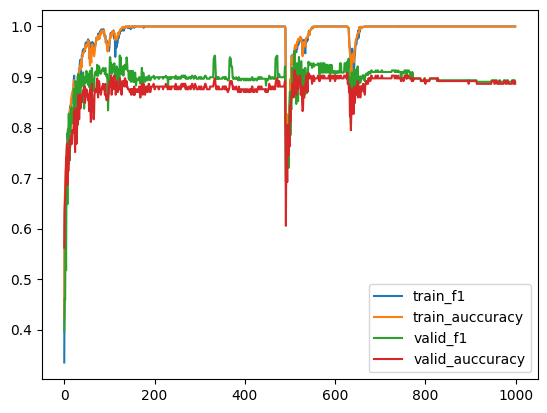

In [8]:
plt.plot(train_f1, label='train_f1')
plt.plot(train_acc, label='train_auccuracy')
plt.plot(valid_f1, label='valid_f1')
plt.plot(valid_acc, label='valid_auccuracy')
plt.legend(loc='best')
plt.show()

# test 결과 확인
- 주요 모달 추출이 목적이기 때문에 이 부분은 의미없음

In [9]:
test_output = []
test_label = []

milnet.eval()
for batch_id, (
    e4Acc, e4Bvp, e4Eda, e4Hr, e4Temp,
    mAcc, mGps, mGyr, mMag,
    emotionPositive, emotionTension, action
) in enumerate(test_dataloader):
    e4Acc = e4Acc.to(device)
    e4Bvp = e4Bvp.to(device)
    e4Eda = e4Eda.to(device)
    e4Hr = e4Hr.float().to(device)
    e4Temp = e4Temp.to(device)
    mAcc = mAcc.to(device)
    mGps = mGps.float().to(device)
    mGyr = mGyr.to(device)
    mMag = mMag.to(device)
    label = emotionTension.long().to(device)
    
    out, _, _, _ = milnet(e4Acc, e4Bvp, e4Eda, e4Hr, e4Temp, mAcc, mGps, mGyr, mMag)

    temp_out = out.detach().cpu().numpy()
    temp_label = label.detach().cpu().numpy()
    test_output += list(temp_out)
    test_label += list(temp_label)
    
print(f'-----------------------------------------------Test--------------------------------------------')
print(f'F1 score: {getF1Score(np.array(test_label), np.argmax(test_output, axis=1))}')
print(f'ACC score: {accuracy_score(np.array(test_label), np.argmax(test_output, axis=1))}')

-----------------------------------------------Test--------------------------------------------
F1 score: 0.8514550596057261
ACC score: 0.8672086720867209
